In [1]:
import pandas as pd
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
from math import ceil
from math import sqrt
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.model_selection import GridSearchCV
import statistics
import sklearn.model_selection as ms
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, ElasticNet 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('train4.csv')
test = pd.read_csv('test4.csv', index_col = 0)
test.loc[:, "YrSoldMinRem"] = test.loc[:, "YrSoldMinRem"].fillna(0)

In [3]:
X = pd.DataFrame(train.iloc[:,:-1])
X = pd.DataFrame(train.iloc[:,1:])
X.head()
y = (train.iloc[:,-1])
y.head()
# settings
#nJobs = psutil.cpu_count()
kFold = 10
X = X.drop(['ylogSalePrice'], axis =1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,6.831328,20.212182,7,5,15.187527,15.187527,9.059126,12.170327,1.0,...,0,0,0,0,1,0,0,0,1,0
1,20,7.221214,20.712205,6,8,15.145138,15.145138,1.000000,13.062832,1.0,...,0,0,0,0,1,0,0,0,1,0
2,60,6.914940,21.347241,7,5,15.184404,15.185966,8.646538,11.200343,1.0,...,0,0,0,0,1,0,0,0,1,0
3,70,6.684507,20.691553,7,5,15.047529,15.135652,1.000000,9.274266,1.0,...,0,0,0,0,1,0,0,0,0,0
4,60,7.314735,22.325160,8,5,15.182841,15.182841,10.391827,11.971129,1.0,...,0,0,0,0,1,0,0,0,1,0


In [4]:
from sklearn.model_selection import train_test_split
# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)
stratify_divide = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
kf = KFold(n_splits = 5, shuffle = True, random_state = 28)
def rmse_cv(model):
    kf = KFold(n_splits = 5, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [5]:
rforest = RandomForestRegressor()

rforest.set_params(random_state=52)

# Train the model on training data
rforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=False)

In [6]:
print("The train set R^2 is: %.5f" % rforest.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % rforest.score(X_test, y_test))

The train set R^2 is: 0.97597
The test set R^2 is is: 0.83591


In [7]:
# Initial prediction
rforest_pred = rforest.predict(X_test)

# Calculate the absolute errors
errors = abs(np.expm1(rforest_pred) - np.expm1(y_test))

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, rforest_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, rforest_pred)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test))
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')

Mean Absolute Error (MAE): $ 17437.61
Mean Squared Error (MSE): 0.023367883440618572
Root Mean Square Error (RMSE): 0.15286557310466792
Mean Absolute Percent Error (MAPE): 10.74 %.


In [9]:
def generate_submission(model, X):
    suffix = model.__class__.__name__.lower()
    y_pr = model.predict(X)
    result = np.exp(y_pr)
    submission = pd.DataFrame({'Id': X.index.values, 'SalePrice': result})
    submission.to_csv("submission_" + suffix + ".csv", index=None)

In [8]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
param_grid ={'max_depth': [20, 25, 30],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'min_samples_leaf':[1, 3, 5],
             'n_estimators': [500, 750, 1000, 1250, 1500]}

In [10]:
grid_search_rforest = ms.GridSearchCV(rforest, param_grid, scoring='neg_mean_squared_error', 
                                     cv= kf, n_jobs=-1, return_train_score = True)

%time grid_search_rforest.fit(X_train, y_train)

CPU times: user 35.2 s, sys: 1.11 s, total: 36.3 s
Wall time: 1h 6min 26s


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=52, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [20, 25, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 3, 5], 'n_estimators': [500, 750, 1000, 1250, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [11]:
# get the best parameters
grid_search_rforest.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1500}

In [12]:
# Prediction using the tuned parameters
grid_rforest = grid_search_rforest.best_estimator_

In [13]:
print("The train set R^2 is: %.5f" % grid_rforest.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % grid_rforest.score(X_test, y_test))

The train set R^2 is: 0.98419
The test set R^2 is is: 0.86995


In [14]:
#Prediction with tuned hyperparameters
grid_rforest_pred = grid_rforest.predict(X_test)

# Calculate the absolute errors
errors = abs(np.expm1(grid_rforest_pred) - np.expm1(y_test))

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, grid_rforest_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, grid_rforest_pred)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test))
print('Mean Absolute Percent Error (MAPE):', round(np.mean(mape), 2), '%.')


Mean Absolute Error (MAE): $ 15205.99
Mean Squared Error (MSE): 0.01852010160140373
Root Mean Square Error (RMSE): 0.13608857998158305
Mean Absolute Percent Error (MAPE): 9.39 %.


In [15]:
score = rmse_cv(grid_rforest)
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest score: 0.1410 (0.0192)



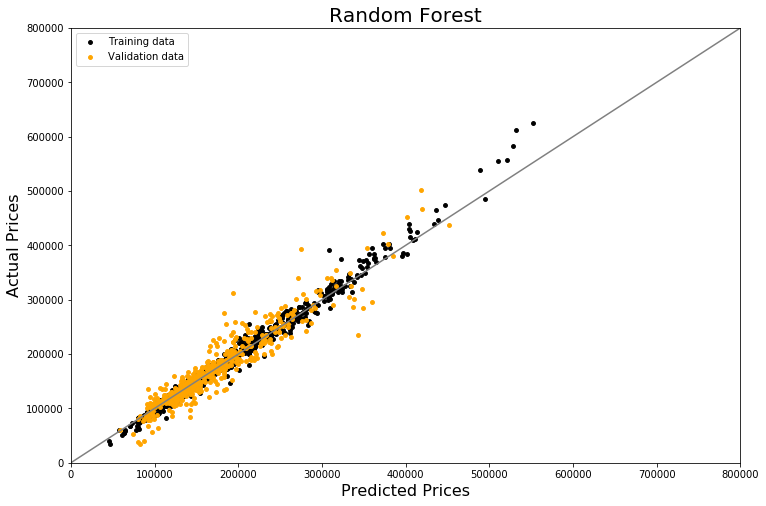

In [16]:
y_train_rForest = grid_rforest.predict(X_train)
y_test_rForest = grid_rforest.predict(X_test)

# Plot predictions
plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_train_rForest), np.expm1(y_train), c='black', marker="o", s=15, label = "Training data")
plt.scatter(np.expm1(y_test_rForest), np.expm1(y_test), c='orange', marker='o', s=15, label = "Validation data")
plt.title("Random Forest", fontsize = 20)
plt.xlabel("Predicted Prices", fontsize = 16)
plt.ylabel("Actual Prices", fontsize = 16)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()

In [17]:
# Random Forest Feature Importance 
# Get numerical feature importances
feats_rf = list(rforest.feature_importances_)

# List of tuples with variable and importance
feats_rf_score = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, feats_rf)]

# Sort the feature importances by most important first
sorted_feats_rf_score = sorted(feats_rf_score, key = lambda x: x[1], reverse = True )

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in sorted_feats_rf_score]

Variable: OverallQual          Importance: 0.51527
Variable: TotalSF              Importance: 0.27076
Variable: GrLivArea            Importance: 0.01966
Variable: LotArea              Importance: 0.01497
Variable: TotalBath            Importance: 0.01212
Variable: CentralAir_Y         Importance: 0.01084
Variable: BsmtFinSF1           Importance: 0.01025
Variable: YrSoldMinRem         Importance: 0.01015
Variable: YearBuilt            Importance: 0.00889
Variable: GarageCars           Importance: 0.00732
Variable: GarageArea           Importance: 0.0071
Variable: BsmtUnfSF            Importance: 0.00709
Variable: OverallCond          Importance: 0.00645
Variable: Percent_BsmtF        Importance: 0.00581
Variable: LotFrontage          Importance: 0.00513
Variable: GarageYrBlt          Importance: 0.00488
Variable: TotalPorchSF         Importance: 0.00423
Variable: BsmtQual_TA          Importance: 0.00407
Variable: YearRemodAdd         Importance: 0.00383
Variable: Exterior1st_BrkComm  I

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Text(0.5, 1.0, 'Feature Importances')

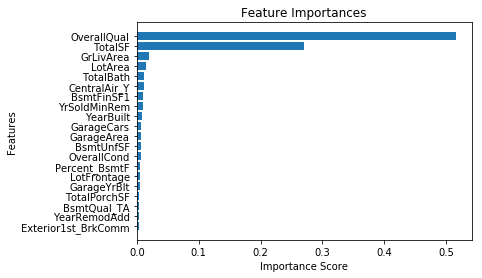

In [18]:
rf_feature_importances_top20 = sorted_feats_rf_score[:20]
featureNames, featureScores = zip(*list(rf_feature_importances_top20))

plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)
plt.gca().invert_yaxis()
plt.title('feature importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importances')

In [25]:
#grid_rforest = grid_search_rforest.best_estimator_
feature_importance = 100.0 * (grid_rforest.feature_importances_ / grid_rforest.feature_importances_.max())
important_features = X_train.columns[feature_importance >= 0]
unimportant_features = X_train.columns[feature_importance < 0]

In [26]:
X_train_reduced = X_train.drop(unimportant_features, axis=1)
X_test_reduced = X_test.drop(unimportant_features, axis=1)

In [27]:
# GridSearchCV for multiple hyperparameters:
rForest_feats = RandomForestRegressor()

param_grid ={'max_depth': [10, 20, 30, 40, 50],
             'max_features': ['auto','sqrt','log2'],
             'min_samples_split':[2,3,4],
             'n_estimators': [100, 300, 500, 800]}

rForest_feats.set_params(random_state=42)

grid_search_rForest2 = GridSearchCV(rForest_feats, param_grid, scoring= 'neg_mean_squared_error',
                           cv= kf, n_jobs = -1, return_train_score=True, verbose = 1)
grid_search_rForest2.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 14.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=28, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30, 40, 50], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 3, 4], 'n_estimators': [100, 300, 500, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [28]:
# get the best parameters
grid_search_rForest2.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 800}

In [29]:
# Use the forest's predict method on the test data
predictions_tuned_rForest2 = grid_search_rForest2.best_estimator_.predict(X_test_reduced)

# Calculate the absolute errors
errors = abs(np.expm1(predictions_tuned_rForest2) - np.expm1(y_test))

# Print out the mean absolute error (MAE)
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('MSE:', mean_squared_error(y_test, predictions_tuned_rForest2))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions_tuned_rForest2)))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.expm1(y_test))

# Calculate and display MAPE
#accuracy = 100 - np.mean(mape)
print('MAPE:', round(np.mean(mape), 2), '%.')


Mean Absolute Error (MAE): $ 15299.35
MSE: 0.018705316123237028
RMSE: 0.13676737960214427
MAPE: 9.41 %.


In [30]:
#test.loc[:, "YrSoldMinRem"] = test.loc[:, "YrSoldMinRem"].fillna(0)
test_rForest = grid_rforest.predict(test)
test_predictions_tuned_rForest2 = grid_search_rForest2.best_estimator_.predict(test)

In [31]:
test_predictions_tuned_rForest2

array([11.74651137, 11.93335376, 12.09827619, ..., 11.98532981,
       11.63964011, 12.32442648])

In [34]:
#Ids = np.arange(1461, 2920, 1)
#test_rForest = np.exp(test_rForest) - 1
pred = pd.DataFrame({'Id': Ids,'SalePrice': test_rForest})

pred.to_csv('predication4.csv', index = False)

In [35]:
#Kaggle Score : 0.14460

,Id,SalePrice
0,1461,125196.629329
1,1462,152657.123451
2,1463,180418.610947
3,1464,182930.031490
4,1465,193760.063417
5,1466,179496.593969
6,1467,172836.004267
7,1468,172534.587568
8,1469,192444.992603
9,1470,125066.383441
